<a href="https://colab.research.google.com/github/ZhiyanAbdallah/PRODIGY_ML_01/blob/main/linear_regression_prediction_for_house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [10/100], Loss: 39039242240.0000
Epoch [20/100], Loss: 39039127552.0000
Epoch [30/100], Loss: 39038959616.0000
Epoch [40/100], Loss: 39038726144.0000
Epoch [50/100], Loss: 39038390272.0000
Epoch [60/100], Loss: 39037911040.0000
Epoch [70/100], Loss: 39037239296.0000
Epoch [80/100], Loss: 39036313600.0000
Epoch [90/100], Loss: 39035072512.0000
Epoch [100/100], Loss: 39033466880.0000


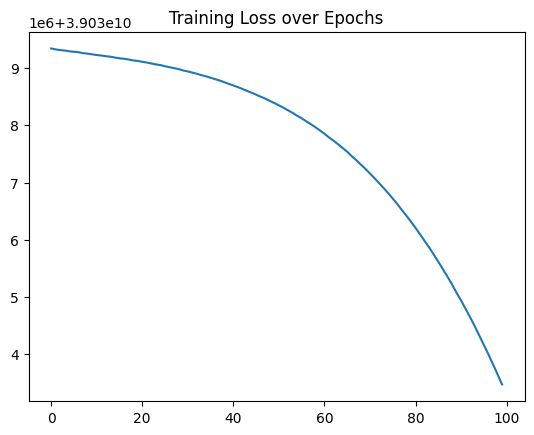

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load train and test data directly
train_data_path = '/content/drive/My Drive/train.csv'  # Update this path as needed
test_data_path = '/content/drive/MyDrive/test.csv'    # Update this path as needed

# Load the train and test datasets
try:
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
except FileNotFoundError:
    print("Error: Dataset not found. Please check the file paths and try again.")
    exit()

# Fill missing values in numeric columns with the mean value
numeric_cols = train_data.select_dtypes(include=['number']).columns
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].mean())

# Select features based on the dataset
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BedroomAbvGr', 'FullBath', '1stFlrSF']
X_train = train_data[features]
y_train = train_data['SalePrice']
X_test = test_data[features]

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Define the neural network model
class HousePriceModel(nn.Module):
    def __init__(self, input_size):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input to hidden layer 1
        self.fc2 = nn.Linear(64, 32)          # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(32, 1)           # Hidden layer 2 to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation after layer 1
        x = torch.relu(self.fc2(x))  # ReLU activation after layer 2
        x = self.fc3(x)              # No activation for the output
        return x

# Instantiate the model, loss function, and optimizer
model = HousePriceModel(input_size=X_train_tensor.shape[1])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plotting the training loss
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.show()

# Function to get user input for prediction
def get_user_input():
    try:
        overall_qual = float(input("Enter Overall Quality (1-10): "))
        gr_liv_area = float(input("Enter Ground Living Area (in square feet): "))
        garage_cars = float(input("Enter number of cars the garage can hold: "))
        garage_area = float(input("Enter Garage Area (in square feet): "))
        total_bsmt_sf = float(input("Enter Total Basement Area (in square feet): "))
        bsmt_unf_sf = float(input("Enter Unfinished Basement Area (in square feet): "))
        bedroom = float(input("Enter Number of Bedrooms Above Ground: "))
        full_bath = float(input("Enter Number of Full Bathrooms: "))
        first_flr_sf = float(input("Enter 1st Floor Area (in square feet): "))

        return [[overall_qual, gr_liv_area, garage_cars, garage_area, total_bsmt_sf, bsmt_unf_sf, bedroom, full_bath, first_flr_sf]]
    except ValueError:
        print("Error: Please enter valid numeric values.")
        return None

# Get and process user data
user_data = get_user_input()
if user_data:
    try:
        user_data_scaled = scaler.transform(user_data)
        user_data_tensor = torch.tensor(user_data_scaled, dtype=torch.float32)

        # Make prediction
        model.eval()
        with torch.no_grad():
            user_prediction = model(user_data_tensor)
        print(f"The predicted house price is: ${user_prediction.item():.2f}")
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
else:
    print("Prediction skipped due to invalid input.")
